# Installs & Imports

In [1]:
!python --version # requires 3.7+

Python 3.8.0


In [2]:
!pip install -q wget chess seaborn numpy pandas

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import wget, chess, bz2, time
from chess import pgn
from pathlib import Path
import seaborn as sns
sns.set_theme(style="whitegrid")
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from pprint import pprint
import matplotlib.pyplot as plt

# Classes & Functions

## Data

In [32]:
def download(url, filename, overwrite=False):
    
    if '.pgn' not in filename:
        filename += '.pgn'
        pgn_filename = filename
    else:
        if not filename.endswith('.pgn'):
            idx = filename.find('.pgn') + 4
            pgn_filename = filename[:idx]
        else:
            pgn_filename = filename
            
    filename = Path(filename)
    if not filename.exists() or overwrite:
        print(f'Downloading {str(filename)} from {url}')
        filename = wget.download(str(url), str(filename))
        if filename.endswith('.bz2'):
            filename = bunzip(filename)
    else:
        print(f'{str(filename)} already exists. Pass in `overwrite=True` to overwrite it.')
        
    return pgn_filename

def bunzip(filename):
    zipped_filename = Path(filename)
    unzipped_filename = zipped_filename.with_suffix('')
    with open(unzipped_filename, 'wb') as f_out:
        with bz2.open(zipped_filename, 'rb') as f_in:
            f_out.write(f_in.read())
            print(f"Wrote {str(unzipped_filename)}")
            return unzipped_filename

def get_avg_elo(game):
    if not game.headers['WhiteElo'].endswith('?') \
                and not game.headers['BlackElo'].endswith('?'):
        avg_elo = (int(game.headers['WhiteElo']) + int(game.headers['BlackElo'])) / 2
        return avg_elo
    else:
        return None

def get_moves(game):
    return [move.san() for move in game.mainline()]

def get_moves_generator(game):
    for move in game.mainline():
        yield move.san()

def games_generator_from_file(filename,
                              max_games=None,
                              sample=1.0):
    pgn_file = open(filename)
    count = 0
    game = pgn.read_game(pgn_file)
    while game:
        if np.random.random() < 0.1:
            game_dict = dict(game.headers)
            game_dict['moves'] = get_moves(game)
            if date := game_dict.get('UTCDate', None):
                year, month, day = date.split('.')
                game_dict['year'] = int(year)
                game_dict['month'] = int(month)
                game_dict['day'] = int(day)
            game_dict['avg_elo'] = get_avg_elo(game)
            yield game_dict
            count += 1

            if max_games and count >= max_games:
                break
        
        game = pgn.read_game(pgn_file)

## Utilities

In [5]:
def round_nearest(x, n):
    return np.round(np.array(x) / n).astype(int) * n

def time_profile(fn):
    def new_fn(*args, **kwargs):
        start_t = time.time()
        ret = fn(*args, **kwargs)
        end_t = time.time()
        print(f'{fn.__name__} took {end_t - start_t:.2f}s')
        return ret
    return new_fn

## Trie

In [6]:
@time_profile
def make_game_trie(games, root=None):
    root = root or dict()
    for game in games:
        current_dict = root
        for move in game['moves']:
            current_dict = current_dict.setdefault(move, {})
        if None not in current_dict:
            current_dict[None] = []
        current_dict[None].append(game)
    return root

def in_trie(trie, moves):
    current_dict = trie
    for move in moves:
        if move not in current_dict:
            return False
        current_dict = current_dict[move]
    return True

def get_sub_trie(trie, moves):
    current_dict = trie
    for move in moves:
        if move not in current_dict:
            return None
        current_dict = current_dict[move]
    return current_dict

def count_trie(trie):
    count = 0
    for move, sub_trie in trie.items():
        if not isinstance(sub_trie, dict):
            leaves = sub_trie  # leaves are games
            count += len(leaves)
        else:
            count += count_trie(sub_trie)
    return count

def get_leaves(trie):
    leaves = []
    if isinstance(trie, list):
        for game in trie:
            yield game
    elif isinstance(trie, dict):
        for move, sub_trie in trie.items():
            for game in get_leaves(sub_trie):
                yield game

## Statistics

In [28]:
def get_move_to_games_mapping(trie, elo_min=0, elo_max=float('inf')):
    move_to_games = {}
    
    for move, sub_trie in trie.items():
        games = list(get_leaves(sub_trie))
        move_to_games[move] = games
        
    return move_to_games

def build_move_df(trie, **kwargs):
    data = []
    move_to_games = get_move_to_games_mapping(trie, *kwargs)
    for move, games in move_to_games.items():
        for game in games:
            game = game.copy()
            game['move'] = move
            data.append(game)

    move_df = pd.DataFrame(data)
    return move_df

def get_elo_to_move_mapping(trie, bin_width=200):
    elo_to_move = defaultdict(list)

    for move, sub_trie in trie.items():
        for game in get_leaves(sub_trie):
            elo = game['avg_elo']
            rounded_elo = round_nearest(elo, bin_width)
            elo_to_move[rounded_elo].append(move)
            
    return elo_to_move

def normalize(d, target=1.0):
    raw = sum(d.values())
    factor = target / raw
    return {key:value*factor for key,value in d.items()}


# Below = outdated(?)

## Visualization

In [41]:
import matplotlib.ticker as ticker
def plot_move_distribution_by_elo(move_df, bin_width=100, figsize=(8, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    
    g = sns.histplot(ax=ax,
                     x='avg_elo',
                     y=None,
                     hue='move',
                     binwidth=bin_width,
                     stat='count',
                     multiple='fill',
                     legend=True,
                     data=move_df)
    return fig
    
def plot_move_distribution_by_year(move_df, bin_width=1, figsize=(8, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    
    move_df = move_df.copy()
    move_df['year_month'] = round_nearest(move_df['year'].values + (move_df['month'].values / 12).astype(int), bin_width)
    g = sns.histplot(ax=ax,
                     x='year_month',
                     y=None,
                     hue='move',
                     binwidth=bin_width,
                     stat='count',
                     multiple='fill',
                     legend=True,
                     data=move_df)
    g.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:g}'))
    return fig

# Run

In [92]:
#url = 'https://lichess.org/games/export/seaghost27?max=100'
#url = 'https://lichess.org/games/export/DrNykterstein?max=7000'
url = 'https://database.lichess.org/standard/lichess_db_standard_rated_2013-06.pgn.bz2'

filename = Path(url).name.translate(dict.fromkeys(map(ord, '?='), '_'))

pgn_filename = download(url, filename)
print(pgn_filename)

lichess_db_standard_rated_2013-06.pgn.bz2 already exists. Pass in `overwrite=True` to overwrite it.
lichess_db_standard_rated_2013-06.pgn


In [93]:
MAX_GAMES = 1000

games_gen = games_generator_from_file(pgn_filename, MAX_GAMES, sample=0.01)
trie = make_game_trie(games_gen)

make_game_trie took 180.83s


In [94]:
print(count_trie(trie))

1000


In [95]:
#LINE = ['e4', 'c5', 'Nf3', 'Nc6', 'd4', 'cxd4', 'Nxd4', ]  # open sicilian
LINE = []  # 

line_trie = get_sub_trie(trie, LINE)
move_df = build_move_df(line_trie)

In [96]:
move_df.head()

,Event,Site,Date,Round,White,Black,Result,BlackElo,BlackRatingDiff,ECO,...,UTCDate,UTCTime,WhiteElo,WhiteRatingDiff,moves,year,month,day,avg_elo,move
0,Rated Bullet game,https://lichess.org/6r0csqdp,????.??.??,?,abdolrahim,Chesymaster,0-1,1270,+7,C20,...,2013.05.31,22:01:58,1080,-13,"[e4, e5, Bc4, Bc5, Nf3, Qf6, Nc3, c6, d3, h5, ...",2013,5,31,1175.0,e4
1,Rated Classical game,https://lichess.org/6vo26bgq,????.??.??,?,morgan1,mogielica,0-1,1667,+8,C20,...,2013.06.01,22:38:19,1540,-8,"[e4, e5, Bc4, Bc5, Qh5, Qf6, Nf3, Nc6, c3, g6,...",2013,6,1,1603.5,e4
2,Rated Blitz tournament https://lichess.org/tou...,https://lichess.org/2aad5369,????.??.??,?,joseph13,fisherbeer,1-0,1541,-20,C50,...,2013.06.01,00:12:23,1317,+23,"[e4, e5, Bc4, Nc6, Nf3, Bc5, O-O, Nf6, d3, O-O...",2013,6,1,1429.0,e4
3,Rated Classical game,https://lichess.org/3c3whx07,????.??.??,?,mazorra,Rath,0-1,1500,+241,C28,...,2013.06.01,14:14:42,1614,-9,"[e4, e5, Bc4, Nc6, d3, Nf6, Nc3, d6, Bb3, Be6,...",2013,6,1,1557.0,e4
4,Rated Blitz game,https://lichess.org/m1xnflwx,????.??.??,?,MihaSLOVE,Anti07,1-0,1566,-14,C23,...,2013.06.01,17:32:15,1739,+7,"[e4, e5, Bc4, Nc6, Qh5, g6, Qf3, Qf6, c3, a6, ...",2013,6,1,1652.5,e4


## Move counts at different ELOs

In [97]:
ELO_BIN_WIDTH = 200

In [98]:
elos_to_moves = get_elo_to_move_mapping(line_trie, bin_width=ELO_BIN_WIDTH)
elos_to_move_count = {e:Counter(ms) for e, ms in elos_to_moves.items()}
elos_to_move_count_normalized = {e:normalize(C) for e, C in elos_to_move_count.items()}

pd.DataFrame(elos_to_move_count)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

### Top Move Distributions Across ELO and Year

In [99]:
top_n = 5
top_moves = move_df['move'].value_counts().iloc[:top_n].index.values.tolist()
print(top_moves)

top_moves_df = move_df[move_df['move'].isin(top_moves)]

['e4', 'd4', 'c4', 'e3', 'Nf3']


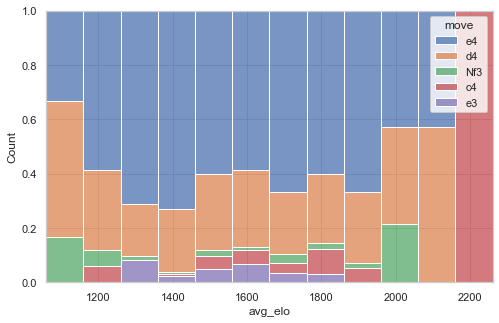

In [100]:
distr_by_elo = plot_move_distribution_by_elo(top_moves_df, 100)

In [103]:
if top_moves_df['year'].nunique() > 1:
    distr_by_year = plot_move_distribution_by_year(top_moves_df, 0.75)

In [104]:
def filter_games(games,
                 white=None,
                 black=None,
                 min_elo=0,
                 max_elo=4000,
                 require_elo=False,
                 time_control=None):
    filtered = []
    for game in games:
        valid = True
        if white and game['White'] != white:
            valid = False
        elif black and game['Black'] != black:
            valid = False
        elif require_elo and not (min_elo < int(game['WhiteElo']) < max_elo):
            valid = False
        elif require_elo and not (min_elo < int(game['BlackElo']) < max_elo):
            valid = False
        elif time_control and game['TimeControl'] != time_control:
            valid = False
        if valid:
            filtered.append(game)
    return filtered

def filter_trie(trie, **kwargs):
    new_trie = {}
    
    for move, sub_trie in trie.items():
        if move == None:
            new_trie[None] = filter_games(sub_trie, **kwargs)
        else:
            new_trie[move] = filter_trie(sub_trie, **kwargs)
    return new_trie

In [105]:
next(get_leaves(filter_trie(line_trie, white='DrNykterstein')))

StopIteration: 

In [106]:
def get_top_lines(trie, k=10, max_depth=6):
    move_df = build_move_df(trie)
    counts = move_df['move'].value_counts()
    frequencies = counts / len(move_df)
    
    lines = []
    for move, sub_trie in trie.items():
        if max_depth == 0:
            score = frequencies[move]
            lines.append((score, [move]))
        else:
            top_sub_lines = get_top_lines(sub_trie, k=10, max_depth=max_depth-1)
            for score, sub_line in top_sub_lines:
                score = (score * len(sub_line) + frequencies[move]) / (len(sub_line) + 1)
            lines.append((score, [move] + sub_line))
    return sorted(lines, reverse=True)[:k]
    

In [107]:
get_top_lines(line_trie)

AttributeError: 'list' object has no attribute 'items'

In [79]:
frequencies

e4     0.35
d4     0.34
Nf3    0.12
c4     0.09
b3     0.03
e3     0.02
Nc3    0.02
d3     0.01
Nh3    0.01
g3     0.01
Name: move, dtype: float64